## Outline
#### 1. Design choices and code structure
#### 2. Demo of usage
#### 3. Summary of results

### Design choices and code structure

The tasks require fast querying of relevant courses, usc or ucla, given a string or course id. Initial tests show that a real-time training/prediction is too slow to be usable.

The system is therefore separated into the following two parts.

1. Offline part. 
    1. crawler.py : crawl functions to crawl, parse and organize the USC and UCLA websites.
    2. preprocessor.py: preprocess the description fields into usable informations
    3. model.py: estimator classes for the trainable algorithms and enable sklearn-style trainning and prediction. The training is done on ordered course pair and the ground truth is taken from a bert model.
    3. dataPreparer.py: call crawl and preprocessor functions to save useful data structures locally in the `data` directory.
    
2. Online part
    1. api.py: offer usable apis the end user can use to perform the required tasks
    
**The two parts are decoupled and the offline part only runs to obtain data/model and the online part runs making use of the data and model.**

The user can perform the tasks without knowing how the offline part works.

Notes:

1. For obtaining ground truth, please refer to the `_pseudoGroundTruth()` function in dataPreparer.py. The t-SNE plot of the ground truth is in the root directory.
2. The training with cross-validation is very hard to obtain on laptop. Therefore, I obtain best parameters from small scale cross-validation and used the parameters to train doc2vec and word2vec models with whole datasets.
3. The similarity scores obtained on USC datasets from various algorithms are zeroed and normalized to fall in the range [-1,1] roughly. However, it is still not recommended to compare them numerically across algorithms.
4. Pre-trained `glove` model is large and requires downloading, not recommended in general. Our trained word2vec model works actually better.
5. Only UCLA Computer Science courses are obtained based on the link provided. It is recommended to only query USC *CSCI*, *EE* or other CS-relevant courses to obtain sensible prediction.
6. There are some *magic numbers* in the code. For example, description shorter than 140 characters are discarded. This is done by manual intervention.
7. The `bert_vecs.npy` is **required** if you want to build all the data/model from scratch.

The t-SNE visualization of USC courses, the pseudo ground truth.
<img src="bert_tsne.png">

### How to use

#### set up an environment and install dependencies

`
virtualenv cour-sine
source cour-sine/bin/activate
pip3 install -r requirements.txt
`

#### run this notebook in the root directory

In [1]:
from crawler import *
from preprocessor import *
from model import Model,word2vecEstimator, doc2vecEstimator
from dataPreparer import initPrepare, splitDataSets
from api import API, dataSaver, uclaDataSaver
%reload_ext autoreload
%autoreload 2

If you didn't download the data directory, you should run the following functions to obtain essential data.

#### Optional, prepare data/model

In [ ]:
# dataSaver() process usc data
#dataSaver() 
#uclaDataSaver()
"""
This may take long time to prepare all the data/model. 
It is recommended to download the json and pickle files in data directory instead. 
"""


#### task 1 (step 5)

In [2]:
api1 = API(model_algo="word2vec")
# obtain an api

In [11]:
api1.stringQuery("Computer science and information technology")
# we obtain the top 10 usc courses

[('INF523', 0.740815947376884),
 ('INF519', 0.6273749754213924),
 ('AME504', 0.5761393749970287),
 ('ISE511', 0.5761393749970287),
 ('CSCI698', 0.5456715462352361),
 ('ITP125', 0.5247774660665223),
 ('EE364', 0.5186429628542043),
 ('AME101', 0.5054647257811945),
 ('INF564', 0.4823314468225002),
 ('CSCI455', 0.4538234187204982)]

In [13]:
api1.stringQuery("Medical biology and its chemical nature.")
# try another string

[('BME620', 0.3476774624888304),
 ('MASC110', 0.3368267264626211),
 ('MEDS504', 0.3347385337453451),
 ('MEDS330', 0.3151141787241474),
 ('INTD620', 0.30326830357491463),
 ('CHE447', 0.25068635806137207),
 ('BIOC581', 0.2501599592884137),
 ('BME452', 0.24565455628183017),
 ('SCRM513', 0.24192726564903963),
 ('AME309', 0.23541384503903667)]

In [8]:
api2 = API(model_algo="Jaccard")

In [23]:
api2.stringQuery("Computer science and information technology")
# we obtain the top 10 usc courses but the results now are different. Note the scores are now in a different range.

[('CSCI495', 0.125),
 ('BME505A', 0.11764705882352941),
 ('CSCI544', 0.11764705882352941),
 ('AME504', 0.10526315789473684),
 ('CSCI591', 0.10526315789473684),
 ('ISE511', 0.10526315789473684),
 ('ITP125', 0.10526315789473684),
 ('EE364', 0.09523809523809523),
 ('EE588', 0.09523809523809523),
 ('ISE440', 0.09523809523809523)]

In [22]:
api2.stringQuery("cancer and neural biology")
# try another string

[('BIOC504', 0.1111111111111111),
 ('CBG504', 0.1111111111111111),
 ('INTD504', 0.1111111111111111),
 ('MICB504', 0.1111111111111111),
 ('BIOC575', 0.08333333333333333),
 ('BME406', 0.07142857142857142),
 ('BIOC581', 0.0625),
 ('PM559', 0.058823529411764705),
 ('CSCI566', 0.05555555555555555),
 ('BIOC561', 0.05263157894736842)]

#### task 2 (step 7.a)

In [4]:
# need to explitly import the courses
import json
import numpy as np
with open("data/coursenames.json","r") as fp:
    coursenames = json.load(fp)

In [5]:
count1 = api1.queryPrereqsCIDs(list(coursenames.keys()))

In [6]:
# Let's only look at those courses who have prerequisites
np.mean(np.array(list(filter(lambda x: x >= 0, count1)))>0)

0.15384615384615385

In [9]:
# Try another model
count2 = api2.queryPrereqsCIDs(list(coursenames.keys()))
np.mean(np.array(list(filter(lambda x: x >= 0, count2)))>0)

0.1794871794871795

#### task 3 (step 7.b)


In [65]:
import random
# randomly select 10 courses
courseIDs = random.sample(list(coursenames.keys()),10)
res = api1.querySameSchoolCIDs(courseIDs)

Top10 related courses of BME502:  ['BME502', 'BME202', 'AME404', 'ITP115', 'EE155', 'AME101', 'BME101', 'CSCI401', 'CSCI662', 'CHE501']
Top10 related courses of AME105:  ['AME105', 'ASTE101', 'ASTE470', 'AME408', 'ASTE520', 'ASTE331A', 'AME101', 'AME504', 'ISE511', 'AME308']
Top10 related courses of ENGR596:  ['ENGR596', 'BIOC596', 'INTD596', 'MBPH596', 'MPHY596', 'PM595', 'CHE550A', 'CHE550B', 'BME567A', 'EE598']
Top10 related courses of ITP348:  ['ITP348', 'INF555', 'EE338', 'ITP304', 'ISE545', 'EE354', 'CSCI201', 'EE577A', 'ITP342', 'BME452']
Top10 related courses of MICB504:  ['BIOC504', 'CBG504', 'INTD504', 'MICB504', 'BIOC575', 'SCRM513', 'SCRM590', 'INTD522', 'MICB522', 'SCRM580']
Top10 related courses of MICB561:  ['BIOC561', 'CNB561', 'INTD561', 'MICB561', 'PATH561', 'PHBI561', 'TRGN514', 'BIOC511', 'TRGN524', 'CHE487']
Top10 related courses of ITP342:  ['ITP342', 'CSCI454', 'EE454', 'CSCI571', 'INF555', 'EE155', 'ITP301', 'ITP348', 'ITP304', 'CSCI526']
Top10 related courses o

In [68]:
# For each of the selected course, the ratio that related courses are from the same school
for course, ratio in zip(courseIDs, res):
    print(str(ratio*100)+"% of related courses of "+ course + " are from the same school of the course." )

100.0% of related courses of BME502 are from the same school of the course.
100.0% of related courses of AME105 are from the same school of the course.
50.0% of related courses of ENGR596 are from the same school of the course.
100.0% of related courses of ITP348 are from the same school of the course.
100.0% of related courses of MICB504 are from the same school of the course.
90.0% of related courses of MICB561 are from the same school of the course.
100.0% of related courses of ITP342 are from the same school of the course.
50.0% of related courses of PM552 are from the same school of the course.
100.0% of related courses of CHE463 are from the same school of the course.
100.0% of related courses of EE542 are from the same school of the course.


#### task 4 (step 7.c)

In [80]:
# CSCI courses, looks pretty accurate
for usccourse in ["CSCI570", "CSCI585", "EE457", "CSCI567", "CSCI402"]:
    print(usccourse)
    print(api1.queryUCLACID(usccourse))

CSCI570
('COMSCI40', '180. Introduction to Algorithms and Complexity')
CSCI585
('COMSCI25', '143. Database Systems')
EE457
('COMSCI94', '251A. Advanced Computer Architecture')
CSCI567
('COMSCI115', '267A. Probabilistic Programming and Relational Learning')
CSCI402
('COMSCI10', '111. Operating Systems Principles')


In [82]:
# However, the Jaccard method looks bad
for usccourse in ["CSCI570", "CSCI585", "EE457", "CSCI567", "CSCI402"]:
    print(usccourse)
    print(api2.queryUCLACID(usccourse))

CSCI570
('COMSCI163', '599. Research for and Preparation of PhD Dissertation')
CSCI585
('COMSCI163', '599. Research for and Preparation of PhD Dissertation')
EE457
('COMSCI163', '599. Research for and Preparation of PhD Dissertation')
CSCI567
('COMSCI163', '599. Research for and Preparation of PhD Dissertation')
CSCI402
('COMSCI163', '599. Research for and Preparation of PhD Dissertation')


#### Some Visualization and offline part code demostration

In [84]:
with open("data/pseudoTruthTable.json","r") as fp:
    TRUTHTABLE = json.load(fp)
uids = list(TRUTHTABLE.keys())

In [86]:
random.seed(2019)
random.shuffle(uids)
uids[:3]  # paired ids

['ENGR345-ISE561', 'AME457-MEDS532', 'ASTE524-PM501']

In [122]:
from dataPreparer import splitDataSets
from preprocessor import Preprocessor
p1 = Preprocessor()
trainSets, testSets = splitDataSets(uids)
model = Model(algo="doc2vec")

In [105]:
uids, desc1, desc2, name1, name2 = model.augmentData(trainSets)
sentences1 = [p1.process(desc) for desc in desc1]
sentences2 = [p1.process(desc) for desc in desc2]

In [123]:
size = 100
# arguments have to be constructed such that it meets the Estimator's standard in order to work with sklearn module.
model.trainCV(uids[:size],[(sentences1[i],sentences2[i]) for i in range(size)])

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CV results: {'mean_fit_time': array([0.12060086, 0.12273884, 0.11975106, 0.12019722, 0.1189096 ,
       0.11972753, 0.15437587, 0.16839536, 0.16498176, 0.15100837,
       0.15231609, 0.15692663, 0.11650825, 0.12427839, 0.12080145,
       0.11694892, 0.11648941, 0.11586968, 0.15610027, 0.15375193,
       0.15039229, 0.15717967, 0.15578802, 0.15687164]), 'std_fit_time': array([0.00245304, 0.00538772, 0.00115011, 0.00260494, 0.00731823,
       0.00541608, 0.00842088, 0.01679562, 0.00534594, 0.00373927,
       0.00307193, 0.00476557, 0.00163397, 0.00650415, 0.00323263,
       0.00085959, 0.00110574, 0.00046953, 0.0046389 , 0.00187552,
       0.00121228, 0.00716273, 0.0019329 , 0.00573221]), 'mean_score_time': array([0.02267583, 0.02532824, 0.02323469, 0.02208408, 0.02150877,
       0.02189342, 0.03264173, 0.0407594 , 0.03424064, 0.03273106,
       0.03315711, 0.03341762, 0.02238671, 0.02335103, 0.02252181,
       0.02208718, 0.02205896, 0.02154644, 0.03276126, 0.03337534,
       0.03458977

In [127]:
model.bestParam

{'alpha': 0.025, 'dm': 1, 'vector_size': 50, 'window': 2}

Take a visual impression of the model's performance.

In [128]:
import matplotlib.pyplot as plt
%matplotlib inline

Note that for some model, the absolute values are not comparable with the pseudo ground truth at the same scale.

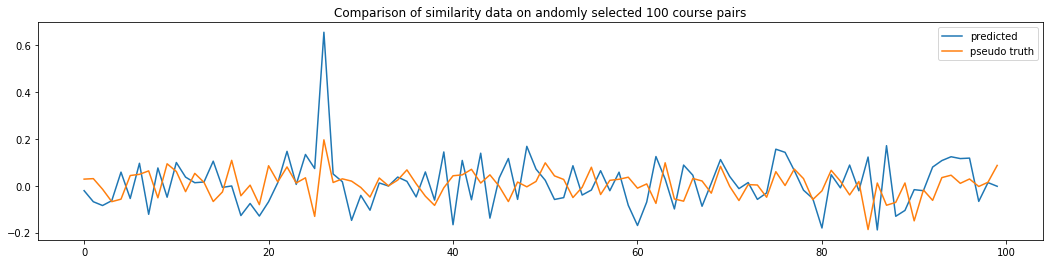

In [138]:
plt.figure(figsize=(18,4))
random.seed(100)
testUIDs = random.sample(testSets,100)
plt.title("Comparison of similarity data on andomly selected 100 course pairs")
plt.plot(np.array(model.predict(testUIDs)),label = "predicted")
plt.plot(np.array([TRUTHTABLE[uid] for uid in testUIDs]),label = "pseudo truth")
_ = plt.legend()

### Summary of results
1. By visual inspections, most of the functionalities work well.
2. The document vector model actually works worse than the word vector model. This may be due to the limited number of total documents.
3. About 15% - 20% of total USC courses which have prerequisites have prerequisite courses in their top3 most relevant courses.
4. The same-school test shows that most relevant courses do almost all come from same school
5. UCLA CS course querying is accurate for typical courses like algorithm, database, machine learning, etc.